In [1]:
import math
from mdp_environment import *
from mdp_batchRL_agent import *
import numpy as np

from tqdm import tqdm_notebook

from copy import deepcopy

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def simulateEpisodes(environment, agent, num_episodes, test_every=50):
    episode = 0
    Q_val_list = []
    param_list = []
    for episode in tqdm_notebook(range(num_episodes)):
        environment.resetCurrentState()
#         print('Episode %d' % (episode, ))
        while (True):
            state = environment.getCurrentState()
            action = agent.getAction(state, train=True)
            reward, next_state, is_terminal = environment.takeAction(action)
            agent.update((state, action, reward, next_state), is_terminal)
            if (is_terminal):
                break

        Q_val_list.append(agent.getQValuesFromStateList([MDPState(i) for i in range(environment.num_states)]))
        param_list.append(agent.getParameterValues())
        
        if (episode % test_every == 0):
            environment.resetCurrentState()
            cumulative_reward = 0.0
            decay = 1.0
            while (True):
                state = environment.getCurrentState()
                action = agent.getAction(state, train=False)
                reward, next_state, is_terminal = environment.takeAction(action)
                cumulative_reward += decay * reward
                decay *= environment.gamma
                if (is_terminal):
                    break
            
            print('\rtesting result %f' % (cumulative_reward, ), end='')
        
    return Q_val_list, param_list


In [3]:
def printD(agent, index):
    for d in agent.D[index]:
        print(d[0].num, d[1], d[2], d[3].num)

In [121]:
np.random.seed(0)
torch.manual_seed(0)

environment = MDPEnvironment(mdp_file_path='mdp_data/mdp_3_3.dat')
learning_hparams = {'learning_rate' : 0.0002, 'momentum' : 0.0, 'batch_size' : 16, 'reg' : 0.0015, 'importance_retain_factor' : 0.01}
agent = BatchRLAgent(ER_epochs=500, episodes_per_batch=5, epsilon=0.1, 
                        gamma=environment.gamma, learning_hparams=learning_hparams, 
                        multi_output=False, gpu_id=-1, 
                        encoding_type='binary')
dropout_input = 0.0
dropout_hidden = 0.0
agent.initQNetwork(environment.getCurrentState(), MDPAction.all_actions, 
                    dropout_input, dropout_hidden, 
                    num_layers=3, hidden_dim=4)

In [122]:
num_episodes = 750
Q_val_list, param_list = simulateEpisodes(environment, agent, num_episodes)

testing result -1.0000000


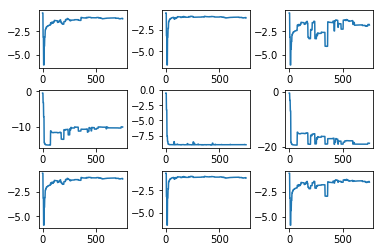

In [123]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
jm = environment.num_states
km = environment.num_actions
for l in range(1, jm*km+1):
    ax = fig.add_subplot(jm, km, l)
    q_temp = [Q_val_list[i][int((l-1)/km)][(l-1)%km] for i in range(len(Q_val_list))]
    ax.plot(q_temp)

# q_temp = [Q_val_list[i][0][0] for i in range(len(Q_val_list))]
# plt.plot(q_temp)
plt.show()

In [124]:
for s in range(environment.num_states):
    state = MDPState(s)
    print('state %d' %(s, ), end=' ')
    for a in state.getLegalActions():
        print(agent.getQValue(state, a), end=' ')
    print('')

state 0 -1.1380842924118042 -1.0920857191085815 -1.8318791389465332 
state 1 -10.137672424316406 -9.004383087158203 -18.675188064575195 
state 2 -1.1364014148712158 -1.0911632776260376 -1.4959566593170166 


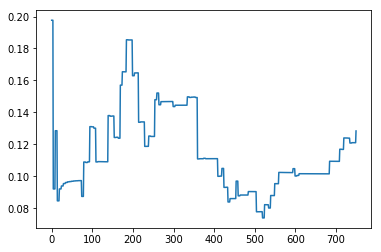

In [125]:
temp_param_list = []
for i in range(len(param_list)):
    temp_param_list.append(param_list[i][1][0])
plt.plot(temp_param_list)
plt.show()

In [60]:
p_numpy = []
for p in agent.Q.parameters():
    p_numpy.append(deepcopy(p.to(agent.cpu_device).detach().numpy()))

In [ ]:
print(p_numpy)

In [ ]:
MDPState(0).getEncoding()